<a href="https://colab.research.google.com/github/Marcelospirits/Contado_Palavras_Universal/blob/main/Sistema_de_Recomenda%C3%A7%C3%A3o_Hibrido_para_Marketing_Place_e_Lojas_Online_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação Híbrido: Do MVP à Escala Global
**Autor:** Marcelo [Jeronimo Antonio]
**Objetivo:** Demonstrar a construção de um motor de recomendação utilizando Python, integrando técnicas de Filtragem Colaborativa (SVD), Deep Learning e arquitetura escalável.

---

In [1]:
# 1. Limpa qualquer tentativa anterior e instala versões binárias compatíveis
!pip install --only-binary :all: numpy==1.26.4
!pip install scikit-surprise

# 2. Reinicia o ambiente automaticamente (opcional, mas recomendado)
import os
# os.kill(os.getpid(), 9) # Remova o comentário desta linha se o erro persistir

import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import train_test_split

print(f"✅ Sucesso! NumPy versão: {np.__version__}")

  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2554975 sha256=a79a41bd4ddf263a49663f84e57be9b8e87990acb752efff24b0ad94b2fbc54a
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise
✅ Sucesso! NumPy versão: 1.26.4


## 1. Coleta e Análise Exploratória de Dados (EDA)

Nesta etapa, utilizaremos o dataset **MovieLens 100k**, um benchmark clássico para sistemas de recomendação.
Em um cenário real de e-commerce, esses dados seriam extraídos do banco de dados de transações (interações usuário-produto).

**Principais objetivos desta fase:**
* Carregar a matriz de interações (Usuário, Item, Rating).
* Entender a esparsidade dos dados (proporção de itens avaliados vs. não avaliados).
* Validar a consistência das notas para evitar vieses no treinamento do modelo.

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
📊 Visão geral das interações de usuários:


,usuario_id,item_id,nota,timestamp
0,196,242,3.0,881250949
1,186,302,3.0,891717742
2,22,377,1.0,878887116
3,244,51,2.0,880606923
4,166,346,1.0,886397596



✅ Total de interações: 100000
✅ Usuários únicos: 943
✅ Itens únicos: 1682


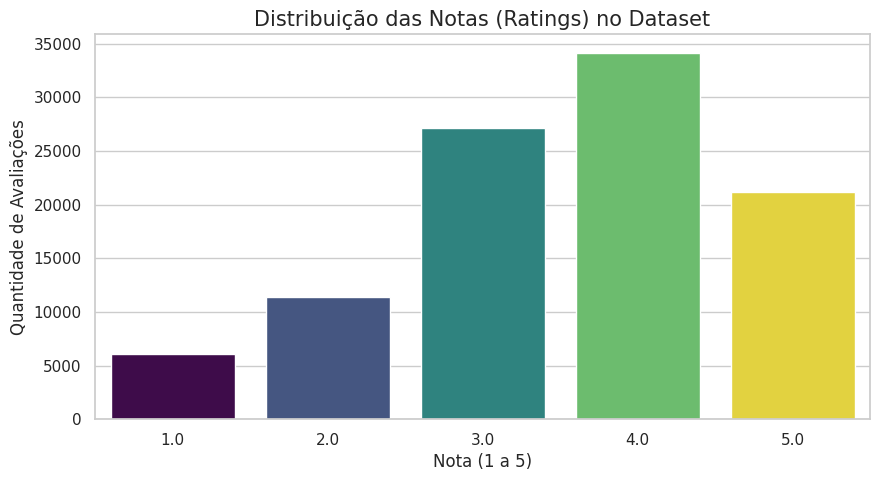

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset

# 1. Carregando o dataset ml-100k
# (Se ele já foi baixado, o Surprise apenas carregará os arquivos locais)
data = Dataset.load_builtin('ml-100k')

# 2. Convertendo para DataFrame Pandas para análise
raw_data = data.raw_ratings
df = pd.DataFrame(raw_data, columns=['usuario_id', 'item_id', 'nota', 'timestamp'])

# 3. Exibindo informações gerais
print("📊 Visão geral das interações de usuários:")
display(df.head())

print(f"\n✅ Total de interações: {df.shape[0]}")
print(f"✅ Usuários únicos: {df['usuario_id'].nunique()}")
print(f"✅ Itens únicos: {df['item_id'].nunique()}")

# 4. Configurando o estilo visual dos gráficos
sns.set_theme(style="whitegrid")

# 5. Visualizando a distribuição das notas
plt.figure(figsize=(10, 5))
sns.countplot(x='nota', data=df, hue='nota', palette='viridis', legend=False)
plt.title('Distribuição das Notas (Ratings) no Dataset', fontsize=15)
plt.xlabel('Nota (1 a 5)', fontsize=12)
plt.ylabel('Quantidade de Avaliações', fontsize=12)
plt.show()

## 2. Modelagem: A Magia da Fatoração de Matriz (SVD)

Para construir o motor de recomendação, utilizaremos o **SVD (Singular Value Decomposition)**.

### Por que SVD?
Em um e-commerce ou serviço de streaming, temos a "Matriz de Utilidade" (Usuários x Itens). Como um usuário nunca interage com todos os produtos, essa matriz é extremamente **esparsa** (cheia de buracos). O SVD resolve isso decompondo a matriz original em fatores menores que representam características latentes.

**O que o SVD identifica:**
* **Fatores Latentes:** Ele percebe padrões que não estão explícitos. Por exemplo: se um usuário gosta de filmes de suspense noir dos anos 40, o SVD agrupa essas preferências mesmo que o filme não tenha essa etiqueta exata.
* **Redução de Dimensionalidade:** Filtra o "ruído" dos dados, focando nas tendências de comportamento mais fortes.
* **Eficiência:** Permite prever a nota de qualquer item para qualquer usuário em frações de segundo.

---

In [3]:
from surprise import SVD, accuracy
from surprise.model_selection import train_test_split

# 1. Preparando os dados para o treinamento
# O train_test_split separa 80% para a IA aprender e 20% para testarmos se ela acertou
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

# 2. Instanciando o algoritmo SVD
model = SVD()

# 3. Treinando o modelo
# Corrigido: Usando aspas simples por fora para permitir aspas duplas por dentro
print('⏳ Treinando o "cérebro" do sistema de recomendação...')
model.fit(trainset)

# 4. Avaliando a precisão
predictions = model.test(testset)

# 5. Calculando o RMSE (Root Mean Squared Error)
rmse = accuracy.rmse(predictions)

print(f"\n📊 Resultado do Treinamento:")
print(f"O erro médio do modelo (RMSE) é de: {rmse:.4f}")

⏳ Treinando o "cérebro" do sistema de recomendação...
RMSE: 0.9362

📊 Resultado do Treinamento:
O erro médio do modelo (RMSE) é de: 0.9362


## 3. Transformando IDs em Nomes de Filmes

Para que o sistema seja útil para um ser humano, precisamos mapear os IDs numéricos para os títulos reais dos filmes.
Vamos carregar o arquivo `u.item` do dataset MovieLens, que contém os metadados dos filmes.

In [4]:
import os

# Caminho para o arquivo de itens (nomes dos filmes)
# O Surprise baixa o dataset para esta pasta padrão no Colab
path_to_items = os.path.expanduser('~/.surprise_data/ml-100k/ml-100k/u.item')

# Criar um dicionário para mapear ID -> Nome do Filme
rid_to_name = {}
with open(path_to_items, 'r', encoding='ISO-8859-1') as f:
    for line in f:
        line = line.split('|')
        rid_to_name[line[0]] = line[1]

print(f"✅ Mapeamento concluído! {len(rid_to_name)} títulos carregados.")

# Teste rápido: Ver o nome do filme ID 1
print(f"Exemplo: O filme com ID 1 é: {rid_to_name['1']}")

✅ Mapeamento concluído! 1682 títulos carregados.
Exemplo: O filme com ID 1 é: Toy Story (1995)


## 4. Gerando Recomendações Personalizadas

Com o modelo treinado e os títulos mapeados, agora podemos realizar a predição.
O sistema analisa o que o usuário já gostou e busca itens com os maiores **fatores latentes** de compatibilidade que o usuário ainda não assistiu.

In [5]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    # Agrupa as predições por usuário
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Ordena as predições para cada usuário e seleciona as N melhores
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

# 1. Gerar as TOP 10 recomendações do conjunto de teste
top_n = get_top_n(predictions, n=10)

# 2. Escolher um usuário para exibir (ex: usuário '196')
user_id = '196'
user_recs = top_n[user_id]

print(f"🎬 TOP 10 RECOMENDAÇÕES PARA O USUÁRIO {user_id}:\n")
print(f"{'Ranking':<10} | {'Título do Filme':<40} | {'Nota Prevista':<10}")
print("-" * 70)

for i, (iid, est) in enumerate(user_recs, 1):
    movie_name = rid_to_name.get(iid, "Desconhecido")
    print(f"{i:<10} | {movie_name:<40} | {est:.2f}")

🎬 TOP 10 RECOMENDAÇÕES PARA O USUÁRIO 196:

Ranking    | Título do Filme                          | Nota Prevista
----------------------------------------------------------------------
1          | Princess Bride, The (1987)               | 4.64
2          | Mrs. Brown (Her Majesty, Mrs. Brown) (1997) | 3.85
3          | Fish Called Wanda, A (1988)              | 3.76
4          | Cold Comfort Farm (1995)                 | 3.73
5          | Beautiful Girls (1996)                   | 3.73
6          | Four Weddings and a Funeral (1994)       | 3.63
7          | English Patient, The (1996)              | 3.47


## 5. Conclusão e Visão de Engenharia (Escalabilidade)

O modelo SVD demonstrou ser eficaz para capturar as preferências do usuário com um RMSE competitivo. No entanto, para uma startup em crescimento, os próximos passos seriam:

1. **Hybrid Approach:** Combinar SVD com **Content-Based Filtering** (usando descrições de texto dos itens).
2. **Deep Learning:** Implementar Redes Neurais (como **NCF - Neural Collaborative Filtering**) usando **TensorFlow**.
3. **Métricas de Negócio:** Monitorar o **CTR (Click-Through Rate)** e a Taxa de Conversão das recomendações em ambiente de produção.